**MRP - Load Prediction using Recurrent Neural Networks for Ontario Electricity Market**

Emmalie Tomini

Ryerson University

The following program uses a recurrent neural network structure to test which weather variables are most important for creating load forecast predictions 24 hours in to the future for the Ontario Electricity Market.

In [69]:
# Import Libraries
import sys
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
%matplotlib inline
import shutil 
from keras.models import Sequential
from keras.layers import Input, Dense, GRU, Embedding
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
from tensorflow.python.keras.initializers import RandomUniform
import h5py
tf.__version__

'1.8.0'

Import the dataset "2008-2017.xlsx", made up of seasonal and weather data collected from Toronto Buttonville Airport weather station.  This dataset contains several weather variables, some of which are more interesting than others.  We will train the RNN on various combinations of features to determine which are necessary to build the most accurate model.

In [47]:
# import load data
load_data = "C:/Users/emmat_000/Desktop/School/Data Science/MRP/2008-2017Load.xlsx"
sheet = "2008-2017Load"
df = pd.read_excel(io=load_data, sheet_name=sheet)

        Date  Year  Month  Day  Day365  Hour  Total Market Demand  \
0 2008-01-01  2008      1    1       1     1                16747   
1 2008-01-01  2008      1    1       1     2                16047   
2 2008-01-01  2008      1    1       1     3                15988   
3 2008-01-01  2008      1    1       1     4                15464   
4 2008-01-01  2008      1    1       1     5                15236   

   Ontario Demand  Temp (°C)  Dew Point Temp (°C)  Rel Hum (%)  \
0           15181       -2.9                 -6.1         79.0   
1           14610       -2.5                 -4.2         88.0   
2           14151       -1.7                 -3.0         91.0   
3           13926       -0.9                 -2.2         91.0   
4           13670       -0.6                 -2.2         89.0   

   Wind Dir (10s deg)  Wind Spd (km/h)  Visibility (km)  Stn Press (kPa)  \
0                 5.0              6.0              2.8            99.04   
1                 7.0              9

Below, we plot "Total Market Demand" over the entire dataset.

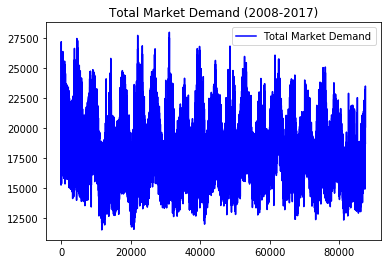

In [48]:
df[['Total Market Demand']].plot(c='b', title='Total Market Demand (2008-2017)')

The x_df dataframe contains our input feature variables.  These include the year, the day, the hour, what day of the week it is, the temperature in degrees celcius, the relative humidity and the dew point temperature.  Select the corresponding features for the appropriate model.

In [49]:
df.fillna(0, inplace=True)
x_df = df[['Year', 'Day365', 'Hour', 'Weekday', 'Temp (°C)', 'Rel Hum (%)', 'Dew Point Temp (°C)']]
y_df = df[['Total Market Demand']]

Our data is constructed in hourly intervals.  Our initial experiment will be to predict the energy demand 24 hours in to the future.  If we want to predict even further in to the future, the day and time step variables are set up to allow such alteration for future experiments.  However, for the time being we will predict electricity load 24 hours in to the future by shifting our output feature, total market demand, 24 steps back.

In [1]:
shift_days = 1
shift_steps = shift_days*24  # Number of hours

Shift our target variable.  We want to predict the future so we shift the y variables up.

In [3]:
y_df = y_df.shift(-shift_steps)

From the previous literature, scalig the variables between 0 and 1 was found t0 increase convergence. This method will be applied the the data using the MinMaxScaler function, default is already 0-1

In [55]:
x_df[len(x_df)-6:]

array([[2017. ,  364. ,   19. ,    7. ,  -13. ,   67. ,   20. ],
       [2017. ,  364. ,   20. ,    7. ,  -14.6,   69. ,   19. ],
       [2017. ,  364. ,   21. ,    7. ,  -15.6,   67. ,   26. ],
       [2017. ,  364. ,   22. ,    7. ,  -17.1,   68. ,   21. ],
       [2017. ,  364. ,   23. ,    7. ,  -18. ,   69. ,   17. ],
       [2017. ,  364. ,   24. ,    7. ,  -18.9,   69. ,   17. ]])

In [56]:
# save an unaltered copy of y_df
y_original = y_df

In [57]:
# Scale x_df
scale_x = MinMaxScaler(copy=False)
scale_x.fit(x_df)
x_df = scale_x.transform(x_df)

# Scale y_df
scale_y = MinMaxScaler(copy=False)
scale_y.fit(y_df)
y_df = scale_y.transform(y_df)

array([[0.31045554],
       [0.30888054],
       [0.30439787],
       ...,
       [0.6120063 ],
       [0.5571844 ],
       [0.52102011]])

Seperate dataset in to training and testing

In [85]:
train_len = int(0.9*(len(x_df)))

x_train = x_df[0:train_len]
y_train = y_df[0:train_len]
y_train_o = y_original[0:train_len] # not rescaled
 
x_test = x_df[train_len:]
y_test = y_df[train_len:]
y_test_o = y_original[train_len:] # not rescaled

Initialize hyper parameters: s_length = sequence length fed to the model for training, b_size = number of sequences, num_f = number of input features

In [60]:
# Sequrnce length of approximatly 2 months , 8 weeks
s_length = 24*7*8  

# Batch size needs to be adjusted in order to acheive best CPU operation
# this value can be adjusted later during testing and experiments
b_size = 150

# During experiments, we may decide to add or remove features to increase
# accuracy.  We will specify the number of x features we are using for each
# experiment and this will be passed as an argument to the batch generator
num_f = 7

Next, we generate atches of sequences, rather than feeding the entire training set sequence in to the algorithm.  Here we can make use of Keras functions to ease the process.

In [61]:
def batchGenerator(b_size, s_length):
    
    while True:
        
            x_dim = (b_size, s_length, num_f)
            x_batch = np.zeros(x_dim)
            
            y_dim = (b_size, s_length, 1)
            y_batch = np.zeros(y_dim)
            
            for i in range(b_size):
                j = np.random.randint(train_len - s_length)
                x_batch[i] = x_train[j:(j+s_length)]
                y_batch[i] = y_train[j:(j+s_length)]
            yield(x_batch, y_batch)

We call our bath generator and create **150** batches, each containing a sequence of 1344 observations.  We verify the structure of our batches by printing their sizes.

In [63]:
gen_batches = batchGenerator(b_size, s_length)
x_batch, y_batch = next(gen_batches)
print(x_batch.shape)
print(y_batch.shape)

(150, 1344, 7)
(150, 1344, 1)


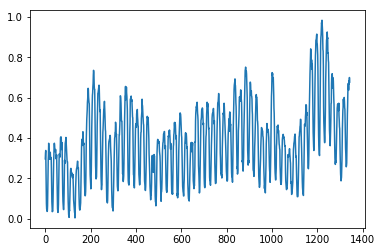

In [64]:
# plot one of the output sequences to check
plt.plot(y_batch[6])

Now, we are prepared to implement our RNN model

In [65]:
# During testing, the optimal number of hidden units can be adjusted
model = Sequential()
model.add(GRU(units=200,
              return_sequences=True,
              input_shape=(None, num_f,)))
model.add(Dense(1, activation='sigmoid', kernel_initializer=RandomUniform(-0.01,0.01)))


Compile Time!!!!

In [70]:
# define optimization function
adam_opt = Adam(lr=0.001, beta_1=0.85, beta_2=0.95, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="mse", optimizer=adam_opt, metrics=['mae', 'acc'])


In [71]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 200)         124800    
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           201       
Total params: 125,001
Trainable params: 125,001
Non-trainable params: 0
_________________________________________________________________


In [72]:
valid_data = (np.expand_dims(x_test, axis=0),np.expand_dims(y_test, axis=0))

(array([[[0.88888889, 1.        , 0.39130435, ..., 0.40345369,
          0.77      , 0.24590164],
         [0.88888889, 1.        , 0.43478261, ..., 0.41758242,
          0.72      , 0.21311475],
         [0.88888889, 1.        , 0.47826087, ..., 0.44740973,
          0.64      , 0.31147541],
         ...,
         [1.        , 0.99452055, 0.91304348, ..., 0.15070644,
          0.68      , 0.3442623 ],
         [1.        , 0.99452055, 0.95652174, ..., 0.13657771,
          0.69      , 0.27868852],
         [1.        , 0.99452055, 1.        , ..., 0.12244898,
          0.69      , 0.27868852]]]), array([[[0.30524594],
         [0.31118246],
         [0.31172765],
         ...,
         [0.6120063 ],
         [0.5571844 ],
         [0.52102011]]]))

We define callback functions to define checkpoints and log progress.

The following callback saves the model after each epoc.

In [73]:
checkpoint_callback = ModelCheckpoint('model_temp_dew_hum.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, period=1)

When the performence worsens, the following callback will implement early stopping

In [74]:
earlyStopping_callback = EarlyStopping(monitor='val_loss', patience=3)


Write to tensorboard callback

In [75]:
tensorboard_callback  = TensorBoard(log_dir='./mrp_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

Models often benefit from reducing the learning rate once learning stagnates.  The following callback reduces the learning rate if loss hasnot improved in the last epoch by multiplying  it by a factor of 2.

In [76]:
reduceLR_callback = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.5,
                                       min_lr=0.0001,
                                       patience=0)

In [77]:
callbacks = [checkpoint_callback,
             earlyStopping_callback,
             tensorboard_callback,
             reduceLR_callback]

Train the model based on the appropriately selected input features.

If you do not intent on training the model, skip to the next line and load the weights from a previously trained model.

In [78]:
%%time
model.fit_generator(generator=gen_batches,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=valid_data,
                    callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - 2138s 21s/step - loss: 0.0172 - mean_absolute_error: 0.1031 - acc: 1.8304e-05 - val_loss: 0.0102 - val_mean_absolute_error: 0.0819 - val_acc: 0.0000e+00
Epoch 2/20
100/100 [==============================] - 2177s 22s/step - loss: 0.0106 - mean_absolute_error: 0.0803 - acc: 2.4008e-05 - val_loss: 0.0062 - val_mean_absolute_error: 0.0636 - val_acc: 0.0000e+00
Epoch 3/20
100/100 [==============================] - 2314s 23s/step - loss: 0.0079 - mean_absolute_error: 0.0690 - acc: 2.5843e-05 - val_loss: 0.0067 - val_mean_absolute_error: 0.0646 - val_acc: 0.0000e+00
Epoch 4/20
100/100 [==============================] - 2499s 25s/step - loss: 0.0070 - mean_absolute_error: 0.0651 - acc: 2.3413e-05 - val_loss: 0.0054 - val_mean_absolute_error: 0.0582 - val_acc: 0.0000e+00
Epoch 5/20
100/100 [==============================] - 2596s 26s/step - loss: 0.0070 - mean_absolute_error: 0.0648 - acc: 2.5347e-05 - val_loss: 0.0053 - val_mean_absolute_e

To load the model weights from a trained model, select the appropriate H5 file.

In [79]:
model.load_weights('model_temp_dew_hum.h5')

Performance on test set, we run the test set in as one long batch

In [80]:
result = model.evaluate(x=np.expand_dims(x_test,axis=0), y=np.expand_dims(y_test, axis=0))


1/1 [==============================] - 1s 977ms/step


In [81]:
print("loss (test-set):", result)

loss (test-set): [0.004640089347958565, 0.0535939522087574, 0.0]


Now we are able to make predictions with our model.

First we run the entire test set through the model and gather the MAPE score.

In [4]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
x = np.expand_dims(x_test, axis=0)
y_pred = model.predict(x)
y_rescale = y_pred[0,:,0]
y_rescale=np.expand_dims(y_rescale, axis=1)
y_pred_rescaled = scale_y.inverse_transform(y_rescale)
y_true = y_test_o
mape_result = mean_absolute_percentage_error(y_true[200:], y_pred_rescaled[200:])
mape_result

Plot the prediction results over the entire test set.

In [ ]:
#plot actual VS predicted
plt.figure(figsize=(15,5))
plt.plot(y_true, label='true')
plt.plot(y_pred_rescaled, label='pred')
plt.ylabel("Total Market Demand")
plt.legend()
plt.show()

Change the length of the test set sequence fed to the model for specific predictions.  For example, below we give the model two weeks worth of input data and plot the last 24 data points, that is, we are making a day ahead load forcast for October 2nd, 2017.

In [6]:
# make prediction
x = np.expand_dims(x_test[6100:6700], axis=0)
y_pred = model.predict(x)
y_rescale = y_pred[0,:,0]
y_rescale=np.expand_dims(y_rescale, axis=1)
y_pred_rescaled = scale_y.inverse_transform(y_rescale)
y_true = y_test_o[6100:6700]

In [7]:
# plot result
#plot actual VS predicted
plt.figure(figsize=(15,5))
plt.plot(y_true[467:491], label='true')
plt.plot(y_pred_rescaled[467:491], label='pred')
plt.ylabel("Total Market Demand")
plt.legend()
plt.show()

In [ ]:
# calculate MAPE
mape_result = mean_absolute_percentage_error(y_true[467:491], y_pred_rescaled[467:491])
mape_result